In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import scipy.stats as stats
import as_functions as asf

sns.set_context('talk')
sns.set_style('darkgrid')
NUM_WEEKS = 181
np.random.seed(23935879)

## Attempting to get it from API

In [2]:
# req = requests.get("https://maps2.dcgis.dc.gov/dcgis/rest/services/DCGIS_DATA/Public_Safety_WebMercator/MapServer/24/query?where=1%3D1&outFields=*&outSR=4326&f=json")






In [3]:
# req.json()

In [4]:
# data = req.json()['features']
# raw_df = pd.DataFrame(data)
# atts = raw_df.attributes.apply(pd.Series)
# geoms = raw_df.geometry.apply(pd.Series)

# df2 = pd.concat([atts, geoms], axis=1)

In [5]:
# df.head()

## Reading From CSV

In [6]:
df = pd.read_csv("Crashes_in_DC.csv")

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df.REPORTDATE = pd.to_datetime(df.REPORTDATE)
df.FROMDATE = pd.to_datetime(df.FROMDATE)
df.TODATE = pd.to_datetime(df.TODATE)
df["report_second"] = df.REPORTDATE.apply(lambda date: date.second)
df["report_minute"] = df.REPORTDATE.apply(lambda date: date.minute)
df["report_hour"] = df.REPORTDATE.apply(lambda date: date.hour)
df['report_day'] = df.REPORTDATE.apply(lambda date: date.day)
df["report_month"] = df.REPORTDATE.apply(lambda date: date.month)
df["report_year"] = df.REPORTDATE.apply(lambda date: date.year)
df["report_day_of_week"] = df.REPORTDATE.apply(lambda date: date.dayofweek)
df["quadrant"] = df.ADDRESS.str.extract(r" ([NS][WE])\b")
df["ward"] = df.WARD.str.extract(r"([1-8])")

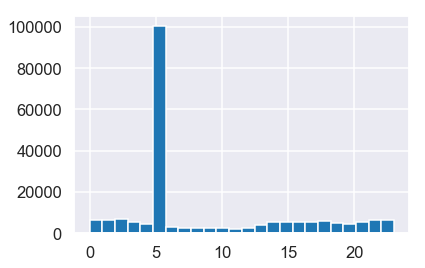

In [8]:
df.report_hour.hist(bins=24)

An abnormal number of crashes are reported at exactly 5 am. This appears to be the fill value if a crash's time is not properly recorded. We will therefore drop these data.

In [9]:
df_except_5_oclock = df[~((df.report_hour == 5) & (df.report_minute == 0) & (df.report_second == 0))]

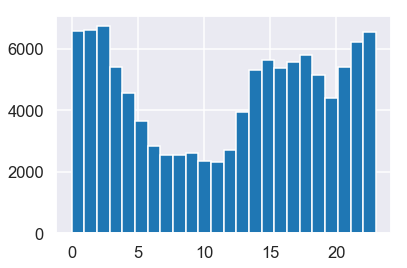

In [10]:
df_except_5_oclock.report_hour.hist(bins=24)

This is much more reasonable.

In [11]:
df2 = df_except_5_oclock[(df_except_5_oclock.report_year > 2015) & (df_except_5_oclock.report_year < 2020)].copy()

In [12]:
day_of_week = {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}

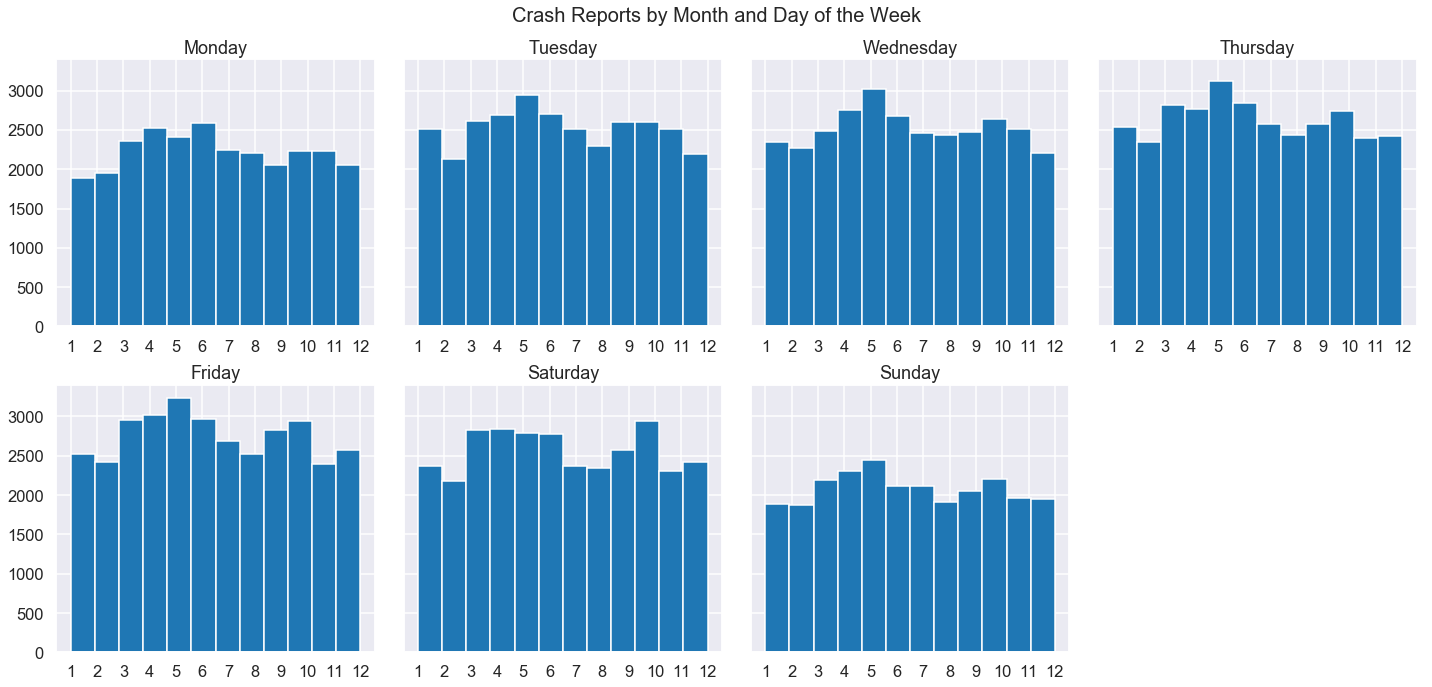

In [13]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,10))
fig.suptitle("Crash Reports by Month and Day of the Week", fontsize=20)
for i in range(7):
    row = i // 4
    col = i%4
    ax[row, col].hist(df.loc[df.report_day_of_week==i,"report_month"], bins=12)
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(1,13))
ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

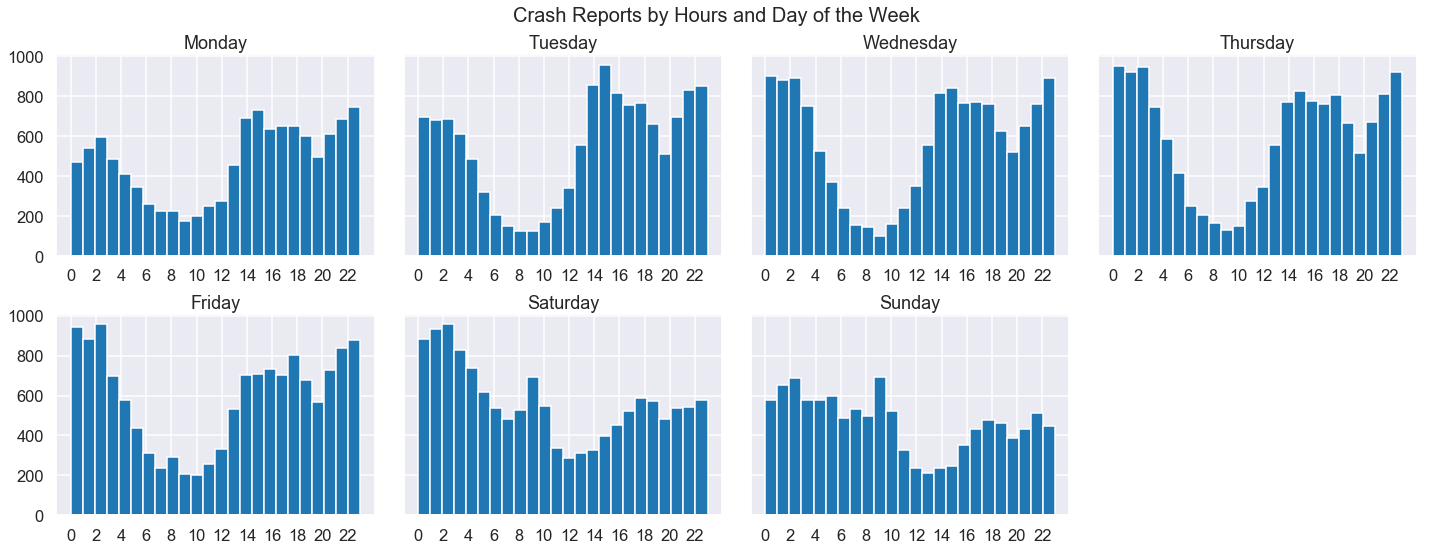

In [14]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(20,8))
fig.suptitle("Crash Reports by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = i // 4
    col = i%4
    ax[row, col].hist(df2.loc[df2.report_day_of_week==i,"report_hour"], bins=24)
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))
ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [15]:
df2['time_of_day'] = df2.report_hour.apply(asf.get_time_of_day)

In [16]:
df2.report_year.value_counts()

2016.0    26548
2017.0    26446
2018.0    26363
2019.0    11926
Name: report_year, dtype: int64

In [17]:
early_morning = df2[(df2.time_of_day == 'Early_Morning')]
rush_hour_morn = df2[df2.time_of_day == 'Rush_Hour_Morning']
day = df2[df2.time_of_day == 'Day']
rush_hour_evening = df2[df2.time_of_day == 'Rush_Hour_Evening']
night = df2[df2.time_of_day == 'Night']

In [18]:
x = pd.Series(df2.groupby(['report_day_of_week',
                           'report_year', 
                           'report_month', 
                           'report_day']).count()['X'])




In [19]:
monday = x.xs(0).values
tuesday = x.xs(1).values
wednesday = x.xs(2).values
thursday = x.xs(3).values
friday = x.xs(4).values
saturday = x.xs(5).values
sunday = x.xs(6).values

monday_padded = asf.pad_array(monday, NUM_WEEKS)
tuesday_padded = asf.pad_array(tuesday, NUM_WEEKS)
wednesday_padded = asf.pad_array(wednesday, NUM_WEEKS)
thursday_padded = asf.pad_array(thursday, NUM_WEEKS)
friday_padded = asf.pad_array(friday, NUM_WEEKS)
saturday_padded = asf.pad_array(saturday, NUM_WEEKS)
sunday_padded = asf.pad_array(sunday, NUM_WEEKS)

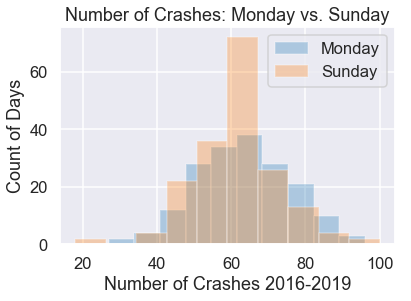

In [20]:
plt.hist(monday, alpha = 0.3, label='Monday')
plt.hist(sunday, alpha=0.3, label='Sunday')
plt.xlabel('Number of Crashes 2016-2019')
plt.ylabel('Count of Days')
plt.title('Number of Crashes: Monday vs. Sunday')
plt.legend()


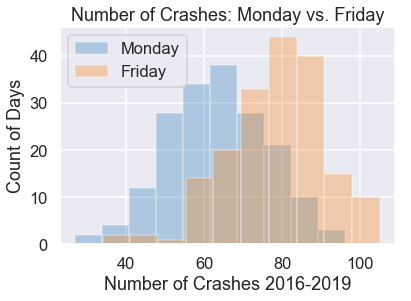

In [21]:
plt.hist(monday, alpha = 0.3, label='Monday')
plt.hist(friday, alpha=0.3, label='Friday')
plt.xlabel('Number of Crashes 2016-2019')
plt.ylabel('Count of Days')
plt.title('Number of Crashes: Monday vs. Friday')
plt.legend()

In [22]:
print(f'T-test: Number of Crashes - Monday vs. Sunday: {stats.ttest_ind(monday, sunday, equal_var=False)}')
print(f'T-test: Number of Crashes - Monday vs. Friday: {stats.ttest_ind(monday, friday, equal_var=False)}')

T-test: Number of Crashes - Monday vs. Sunday: Ttest_indResult(statistic=1.296176919668799, pvalue=0.19575978108253755)
T-test: Number of Crashes - Monday vs. Friday: Ttest_indResult(statistic=-11.595941986328668, pvalue=1.3227792675993172e-26)


In [23]:
y = pd.Series(df2.groupby(['time_of_day',
                           'report_day_of_week',
                           'report_year', 
                           'report_month', 
                           'report_day']).count()['X'])

In [24]:
monday_morn = y.xs('Rush_Hour_Morning').xs(0).values
tuesday_morn =  y.xs('Rush_Hour_Morning').xs(1).values
wednesday_morn =  y.xs('Rush_Hour_Morning').xs(2).values
thursday_morn =  y.xs('Rush_Hour_Morning').xs(3).values
friday_morn =  y.xs('Rush_Hour_Morning').xs(4).values
saturday_morn =  y.xs('Rush_Hour_Morning').xs(5).values
sunday_morn =  y.xs('Rush_Hour_Morning').xs(6).values

monday_rh_evening = y.xs('Rush_Hour_evening').xs(0).values
tuesday_rh_evening = y.xs('Rush_Hour_evening').xs(1).values
wednesday_rh_evening = y.xs('Rush_Hour_evening').xs(2).values
thursday_rh_evening = y.xs('Rush_Hour_evening').xs(3).values
friday_rh_evening = y.xs('Rush_Hour_evening').xs(4).values


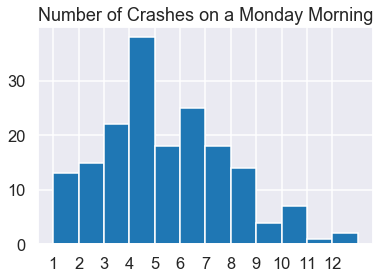

In [25]:
_ = plt.hist(monday_morn, bins=12)
_ = plt.xticks(range(1, 13, 1))
_ = plt.title("Number of Crashes on a Monday Morning")

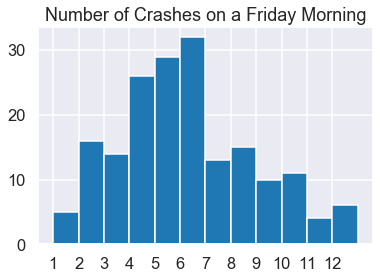

In [26]:
_ = plt.hist(friday_morn, bins=12)
_ = plt.xticks(range(1, 13, 1))
_ = plt.title("Number of Crashes on a Friday Morning")

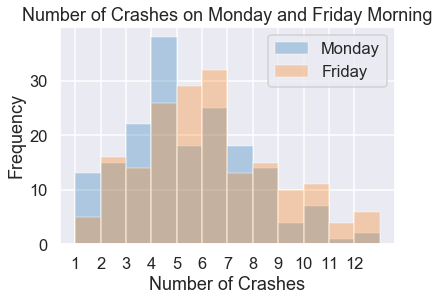

In [27]:
_ = plt.hist(monday_morn, bins=12, alpha=0.3, label="Monday")
_ = plt.hist(friday_morn, bins=12, alpha=0.3, label='Friday')
_ = plt.xticks(range(1, 13, 1))
_ = plt.title("Number of Crashes on Monday and Friday Morning")
_ = plt.ylabel('Frequency')
_ = plt.xlabel('Number of Crashes')
_ = plt.legend()

## Permutation Test for Monday Morning vs. Friday Morning

Because the distribution of number of crashes on Monday morning is not normally distributed, we will instead use a permutation test. Our null hypothesis is that # of crashes on Monday morning is the same as the number of crashes on Friday morning. (The difference in # of crashes is 0.) Monday and Friday are of specific interest to us because of the differing attitudes towards each day. Monday is the start of the week following a weekend, while Friday is the end of the week, where we expect people to be excited for the weekend. 

In [28]:
monday_morn_padded = asf.pad_array(monday_morn, NUM_WEEKS)
friday_morn_padded = asf.pad_array(friday_morn, NUM_WEEKS)

In [61]:
asf.permutation_test(monday_morn_padded, friday_morn_padded, 100000)

0.00039

The associated p-value is small, so we will reject the null hypothesis that the number of crashes in the morning of the two days are the same. This indicates to us that Monday morning has significantly fewer crashes than Friday morning. This could be a result of the people being well rested over the weekend and fatigued at the end of the week, or perhaps people are excited for the weekend and are less careful drivers.

In [30]:
monday_rh_evening_padded = asf.pad_array(monday_rh_evening, NUM_WEEKS)
tuesday_rh_evening_padded = asf.pad_array(tuesday_rh_evening, NUM_WEEKS)
wednesday_rh_evening_padded = asf.pad_array(wednesday_rh_evening, NUM_WEEKS)
thursday_rh_evening_padded = asf.pad_array(thursday_rh_evening, NUM_WEEKS)
friday_rh_evening_padded = asf.pad_array(friday_rh_evening, NUM_WEEKS)

In [31]:
asf.permutation_test(monday_rh_evening_padded, friday_rh_evening_padded, 100000)

0.00075

Looking at evening rush hour, we see a similar pattern: Friday has more crashes than Monday. This again could be fatigue at the end of the week, as well as perhaps people's excitement to get home negatively impacts their driving.

In [32]:
print(f"Permutation Test - Monday vs. Friday Evening: {asf.permutation_test(monday_rh_evening_padded, friday_rh_evening_padded, 100000)}")
print(f"Permutation Test - Tuesday vs. Friday Evening: {asf.permutation_test(tuesday_rh_evening_padded, friday_rh_evening_padded, 100000)}")
print(f"Permutation Test - Wednesday vs. Friday Evening: {asf.permutation_test(wednesday_rh_evening_padded, friday_rh_evening_padded, 100000)}")
print(f"Permutation Test - Thursday vs. Friday Evening: {asf.permutation_test(thursday_rh_evening_padded, friday_rh_evening_padded, 100000)}")

      
      

Permutation Test - Monday vs. Friday Evening: 0.00075
Permutation Test - Tuesday vs. Friday Evening: 0.00022
Permutation Test - Wednesday vs. Friday Evening: 0.01913
Permutation Test - Thursday vs. Friday Evening: 0.01106


Because we have performed multiple tests, we must include an adjustment to the p-value to be more confident we are not making a type-I error. Because we have made 4 comaparisons, we make a Sidak adjustment to
$\alpha_{new} = 1 - (1-\alpha_0)^{1/4} = 1 - (0.95)^{1/4} = 0.0127$. 
At this significance level, it appears that only Wednesday is not significantly different with respect to the number of crashes during evening rush hour. This is interesting to us, as there is no intuitive reason that Wednesday would have as many crashes as Friday. 

## Weekdays vs. weekends
Looking at whether more crashes occur on weekdays or weekends.

In [33]:
weekend = np.append(saturday_padded, sunday_padded)
weekdays = np.append(monday_padded, [tuesday_padded, wednesday_padded, thursday_padded, friday_padded])

In [34]:
asf.permutation_test(weekdays, weekend, 100000)

0.0

In [35]:
asf.permutation_test(saturday_padded, friday_padded, 100000)

0.01372

## Pedestrian Safety

[]

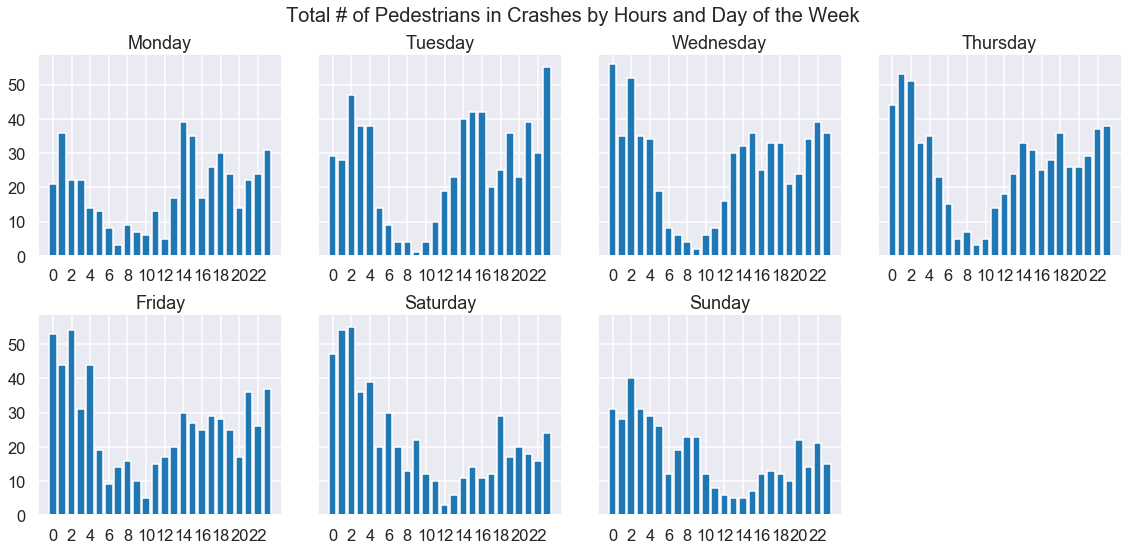

In [36]:
pivot = pd.pivot_table(df2, index="report_hour", columns="report_day_of_week", values="TOTAL_PEDESTRIANS", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Total # of Pedestrians in Crashes by Hours and Day of the Week", fontsize=20)
for i in range(7):
    row = i // 4
    col = i % 4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 2))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])

We see that the number of pedestrians involved in car crashes follows a similar trend to the number of crashes by day of week and hour of day, with a dip between 7 and 10 am on weekdays and around noon on weekends.

In [37]:
peds_inv = df2.groupby(by=['time_of_day',
                           'report_day_of_week',
                           'report_year', 
                           'report_month', 
                           'report_day']).sum().TOTAL_PEDESTRIANS

In [38]:
peds_rh_morn = peds_inv.xs('Rush_Hour_Morning').values
peds_rh_evening = peds_inv.xs('Rush_Hour_evening').values

peds_early_morning = peds_inv.xs('Early_Morning').xs(2).values
peds_night = peds_inv.xs('Night').xs(1).values

In [39]:
asf.permutation_test(peds_rh_morn, peds_rh_evening, 100000)

0.0

In [40]:
z = df2.groupby(['time_of_day',
                 'report_day_of_week',
                 'report_year', 
                 'report_month', 
                 'report_day']).sum().TOTAL_PEDESTRIANS

In [41]:
peds_monday_morn = z.xs('Rush_Hour_Morning').xs(0).values
peds_tuesday_morn =  z.xs('Rush_Hour_Morning').xs(1).values
peds_wednesday_morn =  z.xs('Rush_Hour_Morning').xs(2).values
peds_thursday_morn =  z.xs('Rush_Hour_Morning').xs(3).values
peds_friday_morn =  z.xs('Rush_Hour_Morning').xs(4).values
peds_saturday_morn =  z.xs('Rush_Hour_Morning').xs(5).values
peds_sunday_morn =  z.xs('Rush_Hour_Morning').xs(6).values

peds_monday_rh_evening = z.xs('Rush_Hour_evening').xs(0).values
peds_tuesday_rh_evening = z.xs('Rush_Hour_evening').xs(1).values
peds_wednesday_rh_evening = z.xs('Rush_Hour_evening').xs(2).values
peds_thursday_rh_evening = z.xs('Rush_Hour_evening').xs(3).values
peds_friday_rh_evening = z.xs('Rush_Hour_evening').xs(4).values

In [42]:
peds_morning_commute = np.concatenate((peds_monday_morn,
                                       peds_tuesday_morn,
                                       peds_wednesday_morn,
                                       peds_thursday_morn, 
                                       peds_friday_morn))

peds_evening_commute = np.concatenate((peds_monday_rh_evening, 
                                  peds_tuesday_rh_evening, 
                                  peds_wednesday_rh_evening, 
                                  peds_thursday_rh_evening, 
                                  peds_friday_rh_evening))



Text(0.5, 0, '')

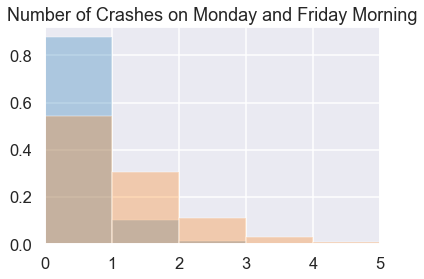

In [43]:
plt.hist(peds_morning_commute, bins=12, alpha=0.3, label="Morning", density=True)
plt.hist(peds_evening_commute, bins=5, alpha=0.3, label='Evening', density=True)
plt.xlim([0, 5])
plt.title("Number of Crashes on Monday and Friday Morning")
plt.xlabel("")

In [44]:
asf.permutation_test(peds_morning_commute, peds_evening_commute, 10000)

0.0

In [45]:
asf.permutation_test(peds_early_morning, peds_night, 100000)

0.01443

This data is evidence that early morning is less safe than night.

In [46]:
df2.columns

Index(['X', 'Y', 'OBJECTID', 'CRIMEID', 'CCN', 'REPORTDATE', 'ROUTEID',
       'MEASURE', 'OFFSET', 'STREETSEGID', 'ROADWAYSEGID', 'FROMDATE',
       'TODATE', 'MARID', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'XCOORD',
       'YCOORD', 'WARD', 'EVENTID', 'MAR_ADDRESS', 'MAR_SCORE',
       'MAJORINJURIES_BICYCLIST', 'MINORINJURIES_BICYCLIST',
       'UNKNOWNINJURIES_BICYCLIST', 'FATAL_BICYCLIST', 'MAJORINJURIES_DRIVER',
       'MINORINJURIES_DRIVER', 'UNKNOWNINJURIES_DRIVER', 'FATAL_DRIVER',
       'MAJORINJURIES_PEDESTRIAN', 'MINORINJURIES_PEDESTRIAN',
       'UNKNOWNINJURIES_PEDESTRIAN', 'FATAL_PEDESTRIAN', 'TOTAL_VEHICLES',
       'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS', 'PEDESTRIANSIMPAIRED',
       'BICYCLISTSIMPAIRED', 'DRIVERSIMPAIRED', 'TOTAL_TAXIS',
       'TOTAL_GOVERNMENT', 'SPEEDING_INVOLVED', 'NEARESTINTROUTEID',
       'NEARESTINTSTREETNAME', 'OFFINTERSECTION', 'INTAPPROACHDIRECTION',
       'LOCATIONERROR', 'LASTUPDATEDATE', 'MPDLATITUDE', 'MPDLONGITUDE',
       'MPDGEOX', 'MPD

## Bikes

In [47]:
bikes_inv = df2.groupby(by=['time_of_day',
                           'report_day_of_week',
                           'report_year', 
                           'report_month', 
                           'report_day']).sum().TOTAL_BICYCLES

In [48]:
bikes_rh_morn = bikes_inv.xs('Rush_Hour_Morning').values
bikes_rh_evening = bikes_inv.xs('Rush_Hour_evening').values

bikes_early_morning = bikes_inv.xs('Early_Morning').xs(2).values
bikes_night = bikes_inv.xs('Night').xs(1).values

In [49]:
asf.permutation_test(bikes_rh_morn, bikes_rh_evening, 100000)

0.0

In [50]:
asf.permutation_test(bikes_early_morning, bikes_night, 100000)

2e-05

# Crash Detail Data

### Crash Details Table is sourced from the DC Government too, and provides information about parties involved in each crash. We looked at states of drivers with different license plate (i.e. DC, MD, VA, and others)

In [53]:
# importing dataset
df_detail = pd.read_csv("Crash_Details_Table.csv")

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
# marging Crash Details Table to the previous DataFrame and re-filter
df_merged = pd.merge(df2, df_detail, how="right", on="CRIMEID")
df_merged = df_merged.loc[~((df_merged.report_hour==5) & (df_merged.report_minute==0) & (df_merged.report_second==0))]
df_merged = df_merged.loc[((df_merged.report_year>2015)&(df_merged.report_year<=2019))]

In [73]:
# cleaning the data and creating boolean columns for driver information
df_merged.loc[df_merged.AGE<=13] = np.nan
df_merged["license"] = df_merged.LICENSEPLATESTATE
df_merged.loc[np.logical_not(df_merged.license.isin(["DC", "VA", "MD"])), "license"] = "other"
df_merged["ticket"] = df_merged.TICKETISSUED == "Y"
df_merged["speeding"] = df_merged.SPEEDING == "Y"
df_merged["impaired"] = df_merged.IMPAIRED == "Y"
df_merged["injury"] = (df_merged.FATAL == "Y") + (df_merged.MAJORINJURY == "Y") + (df_merged.MINORINJURY == "Y")

/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/Users/kmiyaki/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [74]:
# aggregating driver information by states
pivot = df_merged.pivot_table(values = ["ticket", "speeding", "impaired", "injury"], columns="license", aggfunc=["mean", "count"])
pivot

mean                                count                     
license         DC        MD        VA     other     DC     MD     VA  other
impaired  0.016797  0.020149  0.021082  0.007231  48758  42781  19827  55037
injury    0.119406  0.143896  0.116659  0.109617  48758  42781  19827  55037
speeding  0.002892  0.003132  0.003783  0.001017  48758  42781  19827  55037
ticket    0.420731  0.441154  0.471428  0.107673  48758  42781  19827  55037

## There is a general tendency in which DC drivers are less likely to get tickets and be found impaired at crashes, while drivers from Virginia are more likely to receive tickets, commit speeding, be impaired, but less likely to get injured in cases of crashes

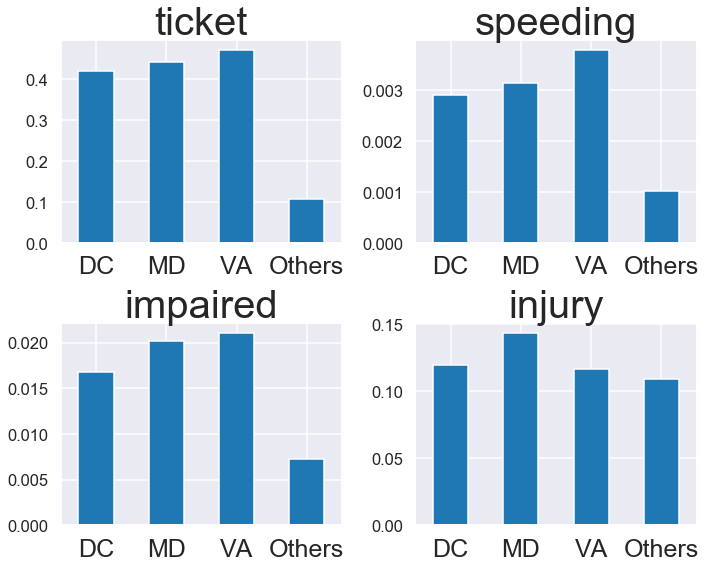

In [59]:
# plotting the aggregated data in bar charts
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
for i, topic in enumerate(["ticket", "speeding", "impaired", "injury"]):
    pivot.loc[topic, "mean"].plot(kind="bar", ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(topic, size=40)
    axes[i//2, i%2].set_xticklabels(["DC", "MD", "VA", "Others"], fontsize=25, rotation=0)
    axes[i//2, i%2].set_xlabel(xlabel="")

fig.subplots_adjust(hspace=0.3)
plt.tight_layout()
fig.patch.set_alpha(0)

### We tested those differences in each pair, and found statistically significant differences in likelihood of getting tickets, being impaired, and being injured among drivers from different states.

In [68]:
for column in ["ticket", "speeding", "impaired", "injury"]:
    for pair in [["DC", "MD"], ["DC", "VA"], ["MD", "VA"]]:
        print(pair[0], pair[1], column)
        print(asf.proportions_test(pair[0], pair[1], topic))

DC MD ticket


AttributeError: module 'as_functions' has no attribute 'proportions_test'

### We just confirmed that more drivers in crashed are impaired on weekend mornings and suspect that drivers from MD and VA drive to DC on Friday/Saturday evenings and are found impaired on the way back to their home states.

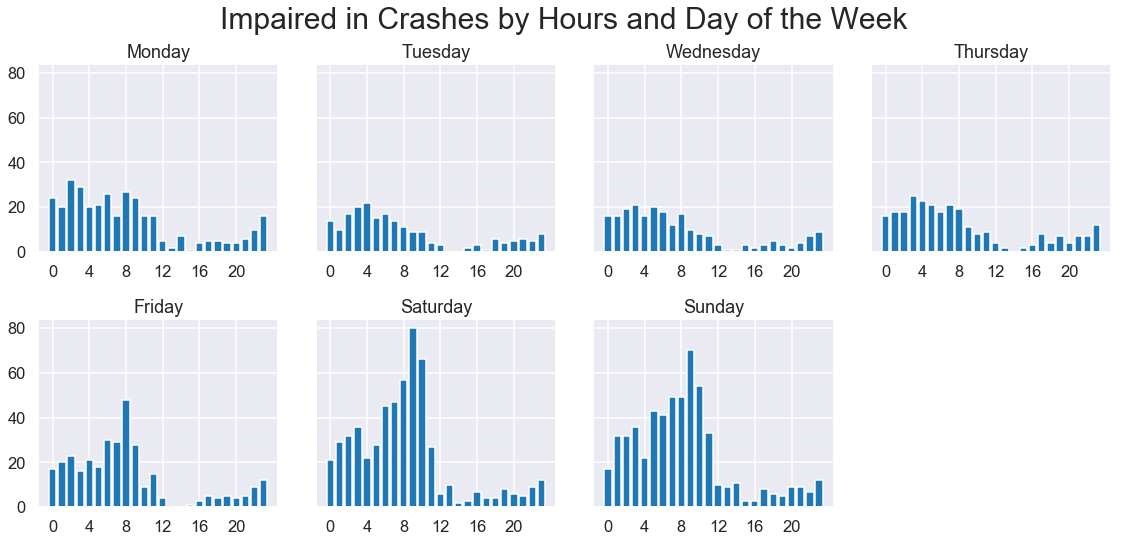

In [67]:
pivot = pd.pivot_table(df_merged, index="report_hour", columns="report_day_of_week", values="impaired", aggfunc=np.sum)
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,8))
fig.suptitle("Impaired in Crashes by Hours and Day of the Week", fontsize=30)
for i in range(7):
    row = int(i/4)
    col = i%4
    ax[row, col].bar(pivot.index, pivot.loc[:,i])
    ax[row, col].title.set_text(day_of_week[i])
    ax[row, col].set_xticks(range(0, 24, 4))

ax[1,3].patch.set_visible(False) 
ax[1,3].set_xticks([])
fig.subplots_adjust(hspace=0.2)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.patch.set_alpha(0)